In [1]:
#import Pkg; Pkg.add("BilevelJuMP")
using Gurobi
const GRB_ENV = Gurobi.Env()
myGurobi = ()->Gurobi.Optimizer(GRB_ENV)
using JuMP
using BilevelJuMP
using Plots
using LinearAlgebra
using Random
Random.seed!(1234);

[ Info: Precompiling Gurobi [2e9cd046-0924-5485-92f1-d5272153d98b]


Set parameter TokenServer to value "lic-gurobi.aalto.fi"


[ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
[ Info: Precompiling BilevelJuMP [485130c0-026e-11ea-0f1a-6992cd14145c]


# Example 5 - Adaptive robust optimization and column-and-constraint generation

We now consider a version of the location-allocation problem, where we decide locations and capacities for a number of $N$ service facilities (servers). The locations are selected from a predefined set $I$, and capacities must be high enough to satisfy an uncertain demand $D$ at a set $J$ of clients.

Let:

- $I$: set of locations
- $J$: set of clients
- $x_{i}$: 1 if server is located at $i \in I$, 0 otherwise.
- $y_{i}$: capacity allocated for server $i \in I$
- $w_{k,j,s}$: flow between server $i \in I$ and client $j \in J$ in scenario $s \in S$
- $z_{j,s}$: shortage at client $j \in J$ in scenario $s \in S$
- $N$: maximum number of servers
- $O_i$: cost of locating server at $i \in I$
- $V_i$: unit capacity cost for the server located at $i \in I$
- $T_{i,j}$: unti transportation cost from $i \in I$ to $j \in J$
- $U$: unmet demand penalty cost
- $D_{j,s}$: demand at client $j \in J$, in scenario $s \in S$

The problem can be stated as follows:

\begin{align*}
    \min&  \sum_{i \in I} (O_{i}x_i + V_iy_i) + \sum_{s}P_s\left(\sum_{i \in I, j \in J} T_{i,j}w_{i,j,s} + \sum_{j \in J} U z_{j,s}\right) \quad & \text{(cost)} \\
    \text{s.t.: } &\sum_{i \in I} x_i \le N  & \text{(max number of servers)}\\
    & \sum_{j \in J} w_{i,j,s}  \le y_i, \ \forall i \in I, s \in S & \text{(capacity of a server)}\\
    & \sum_{j \in J} w_{i,j,s}  \le Mx_i, \ \forall i \in I, s \in S & \text{(server existence)}\\
    & \sum_{j \in J} w_{i,j,s}  \ge D_{j,s} - z_{j,s}, \ \forall j \in J, s \in S & \text{(demand satisfaction)} \\
    & x_i \in \{0,1\}, \ \forall i \in I \\
    & z_{j,s} \ge 0, \ \forall j \in J, s \in S \\
    & w_{i,j,s} \ge 0, \ \forall i \in I, j \in J, s \in S.  
\end{align*}


Once again, let us first define some auxiliary functions that we need for generating instances.

In [2]:
struct Instance
    # sets
    I  # Set of facilities
    J  # Set of clients
    S  # Set of scenarios
    # Parameters 
    N  # Maximum number of facilities
    P  # Probabilities of scenarios s ∈ S 
    O  # Cost of opening facility at i ∈ I
    V  # Variable capacity cost  
    U  # Cost of unmet demand at j ∈ J
    T  # Transportation cost from i ∈ I to j ∈ J
    D  # Demand in location j ∈ J
    bigM  # BigM for capacity constraint
    D_average   # average demand
    D_deviation # max deviation
    loc_i # Coordinates of facilities i ∈ I
    loc_j # Coordinates of clients j ∈ J
end

#=
generate_instance(TotalServers, TotalClients, TotalScenarios):
- inputs:
    1. TotalServers: cardinality of set I
    2. TotalClients: cardinality of set J
    3. TotalScenarios: cardinality of set S
-outputs
    1. Instance: an instance for the problem (::Instance)
=#
function generate_instance(TotalServers, TotalClients, TotalScenarios)
    I = 1:TotalServers
    J = 1:TotalClients
    S = 1:TotalScenarios

    # Parameters
    N = ceil(0.5 * TotalServers)           # Half (rounded up) of all servers can be used
    P = [1/TotalScenarios for s in S]      # All scenarios have equal probability
    O = [rand(40:80) for i in I]           # Cost for locating facility
    V = [rand(1:10) for i in I]            # Capacity cost   
    U = 500                                # High cost for unmet demand
    loc_i = [(rand(), rand()) for i in I]  # Random 2D-coordinates for clients (coordinates are represented by a tuple)
    loc_j = [(rand(), rand()) for j in J]  # Random 2D-coordinates for servers
    
    # The transportation cost is the Euclidean distance between the server i and client j
    T = ceil.(10 .* [sqrt((loc_i[i][1]-loc_j[j][1])^2+(loc_i[i][2]-loc_j[j][2])^2) for i in I, j in J])
    
    D_average = [rand(10:50) for j in J]   # Random demand average for each client           
    D_deviation = [Int(ceil(0.5 * D_average[j])) for j in J] # demand deviation is half of the average
    D = [max(ceil(D_average[j] + rand(-D_deviation[j]:D_deviation[j])), 0) for j in J, s in S] # Random demand deviation per scenario
    max_D, index = findmax(D, dims=2)  # finds maximum among columns
    bigM = sum(max_D)                  # capacity big M
    
    return Instance(I, J, S, N, P, O, V, U, T, D, bigM, D_average, D_deviation, loc_i, loc_j)
end  

#=
unroll_instance(instance::Instance):
- inputs:
    1. Instance: an instance
-output:
    1. I: set I
    2. J: set J
    3. S: set S
    4. N: max servers
    5. P: Probabilities
    6. O: Location cost
    7. V: Capacity cost
    8. U: Unmet demand cost
    9. T: Transportation cost
    10 D: Demand
    11. bigM: bigM value
    12. D_average: average demand value used in uncertainty set 
    13. D_deviation: deviation used in the uncertainty set    
=#
function unroll_instance(instance::Instance)
    I = instance.I 
    J = instance.J
    S = instance.S
    N = instance.N
    P = instance.P
    O = instance.O
    V = instance.V
    U = instance.U
    T = instance.T
    D = instance.D
    bigM = instance.bigM
    D_average = instance.D_average
    D_deviation = instance.D_deviation

    return I, J, S, N, P, O, V, U, T, D, bigM, D_average, D_deviation
end;

Let us generate an instance we can solve rather instantaneously. We consider 5 candidate locations, 20 clients and 50 scenarios.

In [3]:
TotalFacilities = 10
TotalClients = 20
TotalScenarios = 50

# Solving the full space problem for reference
instance = generate_instance(TotalFacilities, TotalClients, TotalScenarios);

Below, we define the functions to generate the model. We generate the common structure first and then use two other functions to add the 2SSP and minimax objective structures.

In [4]:
#=
generate_full_problem_body(instance::Instance):
- inputs
    1. instance: problem instance (::Instance)
-outputs
    1. JuMP model with common structure (::JuMPModel)
=#
function generate_full_problem_body(instance::Instance)
    
    I, J, S, N, P, O, V, U, T, D, bigM = unroll_instance(instance)

    # Initialize model
    m = Model(myGurobi)
    set_silent(m)
    
    # Decision variables
    @variable(m, x[I], Bin)     # 1 if facility is located at i ∈ I, 0 otherwise.
    @variable(m, y[I] >= 0)     # Capacity decided for facility i ∈ I
    @variable(m, w[I,J,S] >= 0) # Flow between facility i ∈ I and client j ∈ J in scenario s ∈ S
    @variable(m, z[J,S] >= 0)   # Shortage in location j ∈ J in scenario s ∈ S

    # Constraints
    # Maximum number of servers
    @constraint(m, numServers,
        sum(x[i] for i in I) <= N
    )
    
    # Capacity limits: cannot deliver more than capacity decided, 
    #   and only if facility was located
    @constraint(m, capBal[i in I, s in S],
        sum(w[i,j,s] for j in J) <=  y[i]
    )

    @constraint(m, capLoc[i in I, s in S], 
        sum(w[i,j,s] for j in J) <= x[i] * bigM
    )
    
    # Demand balance: Demand of active clients must be fulfilled
    @constraint(m, demBal[j in J, s in S],
        sum(w[i,j,s] for i in I) >= D[j,s] - z[j,s]
    )
    
    return m  # Return the generated model
end

generate_full_problem_body (generic function with 1 method)

The distinct structures are essentially modifications in the objective function, with respective additional variables for the minimax model

In [5]:
#=
generate_2SSP_model!(instance, m):
- inputs
    1. instance: problem instance (::Instance) 
    2. m: JuMP model with common structure generated
- outputs
    1. m: model augmented with 2SSP structure
=#
function generate_2SSP_model!(instance, m)
    I, J, S, N, P, O, V, U, T, D, bigM = unroll_instance(instance)
    x = m[:x]
    y = m[:y]
    w = m[:w]
    z = m[:z]

    # The two-stage objective function
    FirstStage = @expression(m, 
        sum(O[i] * x[i] + V[i] * y[i] for i in I) 
    )

    SecondStage = @expression(m, 
        sum(P[s] * (
                sum(T[i,j] * w[i,j,s] for i in I, j in J)
                + sum(U * z[j,s] for j in J)) 
        for s in S)
    )
    
    @objective(m, Min, FirstStage + SecondStage)

    return m
end

#=
generate_minimax!(instance, m):
- inputs
    1. instance: problem instance (::Instance) 
    2. m: JuMP model with common structure generated
- outputs
    1. m: model augmented with minimax structure
=#
function generate_minimax!(instance, m)
    I, J, S, N, P, O, V, U, T, D, bigM = unroll_instance(instance)
    x = m[:x]
    y = m[:y]
    w = m[:w]
    z = m[:z]
    
    @variable(m, θ >= 0)

    FirstStage = @expression(m, 
        sum(O[i] * x[i] + V[i] * y[i] for i in I) 
    )

    @constraint(m, Minimax[s in S], 
        θ >= sum(T[i,j] * w[i,j,s] for i in I, j in J) + sum(U * z[j,s] for j in J)
    )   

    @objective(m, Min, FirstStage + θ)

    return m
end

generate_minimax! (generic function with 1 method)

We can now solve both and compare their solutions.

In [6]:
# Solving 2SSP
model1 = generate_full_problem_body(instance)
expected_value_model = generate_2SSP_model!(instance, model1)
optimize!(expected_value_model)

# Solving the minimax
model2 = generate_full_problem_body(instance)
minimax_model = generate_minimax!(instance, model2)
optimize!(minimax_model)

In [7]:
## Comparing solutions
x_exp = Int.(round.(value.(expected_value_model[:x]).data))
y_exp = value.(expected_value_model[:y])
obj_exp = objective_value(expected_value_model)

x_minmax = Int.(round.(value.(minimax_model[:x]).data))
y_minmax = value.(minimax_model[:y])
obj_minmax = objective_value(minimax_model)

println("2SSP:")
println("   x = ", [x_exp[i] for i in instance.I])
println("   y = ", [y_exp[i] for i in instance.I])
println(" ")
println("Minmax:")
println("   x = ", [x_minmax[i] for i in instance.I])
println("   y = ", [y_minmax[i] for i in instance.I])

2SSP:
   x = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
   y = [0.0, 0.0, 566.0, 259.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 
Minmax:
   x = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
   y = [0.0, 0.0, 506.0, 319.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Column-and-Constraint Generation

Now, we implement the CCG algorithm, starting with functions to generate the main problem (which gives the lower bound) and to add columns and constraints to it.

In [8]:
#=
generate_main(instance):
- Inputs
    1. instance: problem instance (::Instance) 
- Outputs
    1. main: main problem structure (::JuMPModel)
=#
function generate_main(instance)
    
    I, J, S, N, P, O, V, U, T, D, bigM = unroll_instance(instance)
    
    main = Model(myGurobi)
    set_silent(main)
    
    @variable(main, x[I], Bin)
    @variable(main, 0 <= y[I] <= bigM)
    @variable(main, θ)

    @constraint(main, sum(x[i] for i in I) <= N)
    
    @objective(main, Min, sum(O[i] * x[i] + V[i] * y[i] for i in I) + θ)
    
    return main  
end

#=
add_columns_and_constraints(instance, main, d_bar, iter):
- Inputs
    1. instance: problem instance (::Instance) 
    2. main: main problem in its current version (::JuMPModel)
    3. d_bar: demand realisation being used
    4. iter: iteration counter
- Outputs
    1. main: updated main problem structure (::JuMPModel)
=#
function add_columns_and_constraints(instance, main, d_bar, iter)   
    
    I, J, S, K, P, O, V, U, T, D, bigM = unroll_instance(instance)
    
    x = main[:x]
    y = main[:y]
    θ = main[:θ] 
    
    # Adding new variables to the main model. We are registering new variable sets at each iteration,
    # which requires the name of the variable to be passed as a Symbol.
    main[Symbol("w_$(iter)")] = @variable(main, [I,J], lower_bound = 0.0, base_name = "w_$(iter)")
    main[Symbol("z_$(iter)")] = @variable(main, [J], lower_bound = 0.0, base_name = "z_$(iter)")
    
    # For a cleaner code, we allocate to local variables 
    w = main[Symbol("w_$(iter)")]
    z = main[Symbol("z_$(iter)")]
    
    # Add problem constraints for the new variables and demand realisation
    @constraint(main, 
        θ >= sum(T[i,j] * w[i,j] for i in I, j in J) + sum(U * z[j] for j in J) 
    )
    
    @constraint(main, [i in I],
        sum(w[i,j] for j in J) <=  y[i]
    )

    @constraint(main, [i in I], 
        sum(w[i,j] for j in J) <= x[i] * bigM
    )
    
    @constraint(main, [j in J],
        sum(w[i,j] for i in I) >= d_bar[j] - z[j]
    )
      
    return main
end  

#=
solve_main(main):
- Inputs    
    1. main: main problem in its current version (::JuMPModel)
- Outputs
    1. x: x variable value   
    2. y: y variable value
    3. θ: θ variable value
    4. obj: objective value
=#
function solve_main(main)
    optimize!(main)
    return value.(main[:x]), value.(main[:y]), value(main[:θ]), objective_value(main)    
end

solve_main (generic function with 1 method)

In this case, we assume that our uncertainty set is a polyhedral set of the form
\begin{equation*}
   U = \{d \ge 0, g \ge 0 : d_{j} = D_{j} + g_{j} \hat{D}_j, \sum_{j\in J} g_j \le \Gamma \}
\end{equation*}

With that, our subproblem takes the form:

\begin{align*}
   Q(x, y) = \max_{d, g} \min_{w,z} & \sum_{i \in I, j \in J} T_{ij} w_{ij} + \sum_{j \in J} Uz_j \\
   & \color{orange}{\sum_{j \in J} w_{ij} \le y_{i}, \forall i \in I} \quad\quad & \color{orange}{( u_i )} \\
   & \color{orange}{\sum_{j \in J} w_{ij} \le Mx_i, \forall i \in I} & \color{orange}{( q_i )}\\
   & \color{orange}{\sum_{i\in I} w_{ij} \ge d_j - z_j, \forall j \in J} & \color{orange}{( r_j )}\\
   & d_{j} = D_{j} + g_{j} \hat{D}_j, \ \forall j \in J \\
   & \sum_{j\in J} g_j \le \Gamma \\
   & {w_{ij}} \ge 0, \ \forall i \in I, j \in J \\
   & {z_j} \ge 0, \ \forall j \in J.
\end{align*}

Notice that $Q(x, y)$ is a bilevel problem and, like such, requires an appropriate treatment. Let us now explore a few options.


### Primal-dual approach

First, lets use a primal-dual approach, meaning that, since the inner problem (minimisation + orange constraints) is convex, we can pose its optimality conditions (primal and dual feasibility) to the outer problem. This leads to the following equivalent subproblem

\begin{align*}
   \max_{d,g,u,q,r} & \sum_{j \in J} d_jr_j + \sum_{i\in I} Mx_iq_i + \sum_{i \in I}y_iu_i \\
   & \color{orange}{u_i + q_i + r_j \le T_{ij}, \ \forall i \in I, j \in J} \quad\quad & \color{orange}{(w_{ij})} \\
   & \color{orange}{r_j \le U, \ \forall j \in J} & \color{orange}{(z_j)}\\
   & {d_{j} = D_{j} + g_{j} \hat{D}_j, \ \forall j \in J }\\
   & \sum_{j\in J} g_j \le \Gamma \\
   & u_i, q_i \le 0, \ \forall i \in I \\
   & r_j \ge 0, \ \forall j \in J.
\end{align*}

Notice the maximisation of the term $d_jr_j$ which is a convex quadratic term, making the problem nonconvex. The function `generate_and_solve_dualized_subproblem` implements the solution of this subproblem.

In [9]:
#=
generate_and_solve_dualized_subproblem(instance, x_bar, y_bar, Γ):
- inputs
   instance: problem instance (::Instance) 
   2. x_bar: x variable solution passed to the subproblem
   3. y_bar: y variable solution passed to the subproblem
   4. Γ: budget of uncertainty
- outputs
   1. d_bar: value of d variable
   2. opt_value: subproblem optimal value 
=#
function generate_and_solve_dualized_subproblem(instance, x_bar, y_bar, Γ)
    
    I, J, S, N, P, O, V, U, T, D, bigM, D_average, D_deviation = unroll_instance(instance)
     
    sub_dual = Model(myGurobi)
    set_optimizer_attribute(sub_dual, "NonConvex", 2) # Call spatial BB solver
 
    set_silent(sub_dual)
     
    @variable(sub_dual, u[I] <= 0)
    @variable(sub_dual, q[I] <= 0)
    @variable(sub_dual, r[J] >= 0)
    @variable(sub_dual, 0 <= g[J] <= 1)
    @variable(sub_dual, d[J] >= 0)
 
    @constraint(sub_dual, [i in I, j in J], 
       u[i] + q[i] + r[j] <= T[i,j]
    )
    @constraint(sub_dual, [j in J], 
       r[j] <= U
    )
 
    # Uncertainty set
    @constraint(sub_dual, [j in J],
       d[j] == D_average[j] + g[j] * D_deviation[j]
    )
 
    @constraint(sub_dual, [j in J],
       sum(g[j] for j in J) <= Γ
    )
 
    @objective(sub_dual, Max,  
       sum(bigM * x_bar[i] * q[i] for i in I) +
       sum(y_bar[i] * u[i] for i in I) +
       sum(d[j] * r[j] for j in J) 
    )   
    
    optimize!(sub_dual)
     
    d_bar = value.(sub_dual[:d])                     
    opt_value = objective_value(sub_dual)
     
    return d_bar, opt_value
 end

generate_and_solve_dualized_subproblem (generic function with 1 method)

### Linearised primal-dual

Sometimes, it is possible to consider uncertainty sets with binary variables. In the case of our uncertainty set, we can restate it as

\begin{equation*}
   U = \{d \ge 0, g \in \{0,1\} : d_{j} = D_{j} + g_{j} \hat{D}_j, \sum_{j} g_j \le \Gamma \}
\end{equation*}

assuming $\Gamma$ as integer.

\begin{align*}
   \max_{d,g,u,q,r} & \sum_{j \in J} \color{orange}{d_j}r_j + \sum_{i\in I} Mx_iq_i + \sum_{i \in I}y_iu_i \\
   & {u_i + q_i + r_j \le T_{ij}, \ \forall i \in I, j \in J}  \\
   & {r_j \le U, \ \forall j \in J} \\
   & {d_{j} = D_{j} + g_{j} \hat{D}_j, \ \forall j \in J }\\
   & \sum_{j\in J} g_j \le \Gamma \\
   & u_i, q_i \le 0, \ \forall i \in I \\
   & r_j \ge 0, \ \forall j \in J.
\end{align*}

This means we can:
1. Substitute $d_j$ with $D_j + g_j \hat{D}_j$ in the objective function: $d_jr_j=(D_j+g_j\hat{D}_j)r_j = D_jr_j + \hat{D}_jg_jr_j$
2. Employ the exact linearisation on the product $g_jr_j$. Let $b_j$ replace $g_jr_j$. We also need the constraints:

\begin{align*}
   & b_j \le g_j U \\
   & b_j \le r_j \\
   & b_j \ge r_j - U(1 - g_j)
\end{align*}

The last constraint can be dropped becase we are maximising on $b$ with a postive coefficient in the objective function.

Function `generate_and_solve_linearized_subproblem` implements this version of the subproblem, which can be solved as a MIP.

In [10]:
#=
generate_and_solve_linearized_subproblem(instance, x_bar, y_bar, Γ):
- inputs
   1. instance: problem instance (::Instance) 
   2. x_bar: x variable solution passed to the subproblem
   3. y_bar: y variable solution passed to the subproblem
   4. Γ: budget of uncertainty
- outputs
   1. d_bar: value of d variable
   2. opt_value: subproblem optimal value 
=#
 function generate_and_solve_linearized_subproblem(instance, x_bar, y_bar, Γ)
     
   I, J, S, N, P, O, V, U, T, D, bigM, D_average, D_deviation = unroll_instance(instance)
      
   sub_dual = Model(myGurobi) 
   set_silent(sub_dual)
   
   @variable(sub_dual, u[I] <= 0)
   @variable(sub_dual, q[I] <= 0)
   @variable(sub_dual, r[J] >= 0)
   @variable(sub_dual, g[J], Bin)
   @variable(sub_dual, b[J] >= 0)
  
   @constraint(sub_dual, [i in I, j in J], 
      u[i] + q[i] + r[j] <= T[i,j]
   )
   @constraint(sub_dual, [j in J], r[j] <= U)
   @constraint(sub_dual, [j in J], sum(g[j] for j in J) <= Γ)
   @constraint(sub_dual, [j in J], b[j] <= r[j])
   @constraint(sub_dual, [j in J], b[j] <= U * g[j])

   @objective(sub_dual, Max,  
      sum(bigM * x_bar[i] * q[i] for i in I) +
      sum(y_bar[i] * u[i] for i in I) +
      sum(D_average[j] * r[j] + D_deviation[j] * b[j] for j in J) 
   )   
   
   optimize!(sub_dual)
   
   d_bar = [D_average[j] + value(g[j]) * D_deviation[j] for j in J]                 
   opt_value = objective_value(sub_dual)
   
   return d_bar, opt_value
  end

generate_and_solve_linearized_subproblem (generic function with 1 method)

### Bilevel problem perspective

Let us reorganise the structure of the original subproblem to expose its bilevel structure.

\begin{align*}
   Q(x, y) = \max_{d, g} & \sum_{i \in I, j \in J} T_{ij} w_{ij} + \sum_{j \in J} Uz_j \\
   & d_{j} = D_{j} + g_{j} \hat{D}_j, \ \forall j \in J \\
   & \sum_{j} g_j \le \Gamma \\
   & d_j \ge 0, \ \forall j \in J \\
   & g_j \ge 0, \ \forall j \in J \\
   & \quad \min_{w,z} \sum_{i \in I, j \in J} T_{ij} w_{ij} + \sum_{j \in J} Uz_j \\
   & \quad \sum_{j \in J} w_{ij} \le y_{i}, \forall i \in I \\
   & \quad \sum_{j \in J} Mx_i, \forall i \in I \\
   & \quad \sum_{i} w_{ij} \ge d_j - z_j, \forall j \in J \\
   & \quad w_{ij} \ge 0, \ \forall i \in I, j \in J \\
   & \quad z_j \ge 0, \ \forall j \in J.
\end{align*}

Then we can pose it appropriately defining the upper and lower level terms with the package BilevelJuMP, which reformulates the problem and solves it.

In [11]:
#=
generate_and_solve_bilevel_subproblem(instance, x_bar, y_bar, Γ):
- inputs
   1. instance: problem instance (::Instance) 
   2. x_bar: x variable solution passed to the subproblem
   3. y_bar: y variable solution passed to the subproblem
   4. Γ: budget of uncertainty
- outputs
   1. d_bar: value of d variable
   2. opt_value: subproblem optimal value 
=#
function generate_and_solve_bilevel_subproblem(instance, x_bar, y_bar, Γ)
   
   I, J, S, K, P, O, V, U, T, D, bigM, D_average, D_deviation = unroll_instance(instance)
   
   sub_dual = BilevelModel(myGurobi, mode = BilevelJuMP.SOS1Mode()) 
   set_silent(sub_dual)
   
   @variable(Upper(sub_dual), d[J] >= 0)
   @variable(Upper(sub_dual), 0 <= g[J] <= 1)
   @variable(Lower(sub_dual), w[I,J] >= 0)
   @variable(Lower(sub_dual), z[J] >= 0)

   @constraint(Lower(sub_dual), capBal[i in I],
      sum(w[i,j] for j in J) <=  y_bar[i]
   )

   @constraint(Lower(sub_dual), capLoc[i in I], 
      sum(w[i,j] for j in J) <= x_bar[i] * bigM
   )
   
   @constraint(Lower(sub_dual), demBal[j in J],
      sum(w[i,j] for i in I) >= d[j] - z[j]
   )

   # Uncertainty set
   @constraint(Upper(sub_dual), [j in J],
      d[j] == D_average[j] + g[j] * D_deviation[j]
   )

   @constraint(Upper(sub_dual), [j in J], sum(g[j] for j in J) <= Γ)

   @objective(Lower(sub_dual), Min, 
      sum(T[i,j] * w[i,j] for i in I, j in J) + sum(U * z[j] for j in J)
   ) 

   @objective(Upper(sub_dual), Max, 
      sum(T[i,j] * w[i,j] for i in I, j in J) + sum(U * z[j] for j in J)
   ) 
   
   optimize!(sub_dual)
   
   d_bar = [value(d[j]) for j in J]                 
   opt_value = objective_value(sub_dual)
   
   return d_bar, opt_value
end

generate_and_solve_bilevel_subproblem (generic function with 1 method)

We are ready to pose the CCG algorithm, which is implemented in the function `cc_decomposition`

In [12]:
#=
ccg_decomposition(ins; max_iter = 10, Γ = 10, sub_method = :linear): 
- inputs
    1. ins: problem instance (::Instance) 
    2. max_iter: maximum number of iterations
    3. Γ: budget of uncertainty
    4. sub_method: which subproblem solving method
=#
function ccg_decomposition(ins; max_iter = 10, Γ = 10, sub_method = :linear)
    k = 1
    ϵ = 1e-4
    LB = -Inf
    UB = +Inf
    gap = +Inf
    x_bar = zeros(length(ins.I))
    y_bar = zeros(length(ins.J))
    
    println("\nStarting CCG decomposition...")
    start = time()    
    
    if sub_method == :linear
        d_bar, f_sub = generate_and_solve_linearized_subproblem(ins, x_bar, y_bar, Γ);
    elseif sub_method == :dual    
        d_bar, f_sub = generate_and_solve_dualized_subproblem(ins, x_bar, y_bar, Γ);
    elseif sub_method == :bilevel
        d_bar, f_sub = generate_and_solve_bilevel_subproblem(ins, x_bar, y_bar, Γ);
    else    
        error("Invalid subproblem solution method chosen.")
    end

    main = generate_main(ins)
    main = add_columns_and_constraints(ins, main, d_bar, k) 

    while k <= max_iter && gap > ϵ
        x_bar, y_bar, θ_bar, f_main = solve_main(main);
        
        if sub_method == :linear
            d_bar, f_sub = generate_and_solve_linearized_subproblem(ins, x_bar, y_bar, Γ);
        elseif sub_method == :dual    
            d_bar, f_sub = generate_and_solve_dualized_subproblem(ins, x_bar, y_bar, Γ);
        else # if sub_method == :bilevel
            d_bar, f_sub = generate_and_solve_bilevel_subproblem(ins, x_bar, y_bar, Γ);
        end
        
        LB = f_main
        UB = min(UB, f_main - θ_bar + f_sub)
        gap = abs((UB - LB) / UB)
        println("Iter $(k): UB: $(round(UB, digits=2)), LB: $(round(LB, digits=2)), gap: $(round(100*gap, digits=2))%")
        
        if gap <= ϵ
            stop = time()
            println("\nOptimal found.\n Objective value: $(round(UB, digits=2))\n Total time: $(round(stop-start, digits=2))s\n gap: $(round(100*gap, digits=2))%")
            return x_bar, y_bar, UB
        else    
            main = add_columns_and_constraints(ins, main, d_bar, k)
            k += 1
        end
    end
    println("Maximum number of iterations exceeded.")
end

ccg_decomposition (generic function with 1 method)

In [ ]:
@time x_bar, y_bar, UB = ccg_decomposition(instance, max_iter = 10, Γ = 5, sub_method = :linear)
#@time x_bar, y_bar, UB = ccg_decomposition(instance, max_iter = 10, Γ = 5, sub_method = :dual)
@time x_bar, y_bar, UB = ccg_decomposition(instance, max_iter = 10, Γ = 5, sub_method = :bilevel);


Starting CCG decomposition...
Iter 1: UB: 4090.0, LB: 4034.0, gap: 1.37%
Iter 2: UB: 4090.0, LB: 4076.0, gap: 0.34%



Starting CCG decomposition...
Iter 1: UB: 3579.0, LB: 3518.0, gap: 1.7%
Iter 2: UB: 3575.25, LB: 3533.25, gap: 1.17%
Iter 3: UB: 3564.71, LB: 3564.71, gap: 0.0%

Optimal found.
 Objective value: 3564.71
 Total time: 0.13s
 gap: 0.0%

Starting CCG decomposition...
Iter 1: UB: 3789.0, LB: 3710.0, gap: 2.08%
Iter 2: UB: 3725.8, LB: 3725.8, gap: 0.0%

Optimal found.
 Objective value: 3725.8
 Total time: 0.33s
 gap: 0.0%

Starting CCG decomposition...
Iter 1: UB: 3891.0, LB: 3830.0, gap: 1.57%
Iter 2: UB: 3864.25, LB: 3845.25, gap: 0.49%
Iter 3: UB: 3859.48, LB: 3859.48, gap: 0.0%

Optimal found.
 Objective value: 3859.48
 Total time: 1.41s
 gap: 0.0%

Starting CCG decomposition...
Iter 1: UB: 3988.0, LB: 3968.0, gap: 0.5%
Iter 2: UB: 3977.0, LB: 3973.0, gap: 0.1%
Iter 3: UB: 3976.0, LB: 3976.0, gap: 0.0%

Optimal found.
 Objective value: 3976.0
 Total time: 2.59s
 gap: 0.0%

Starting CCG decomposition...
Iter 1: UB: 4090.0, LB: 4034.0, gap: 1.37%
Iter 2: UB: 4090.0, LB: 4076.0, gap: 0.34%

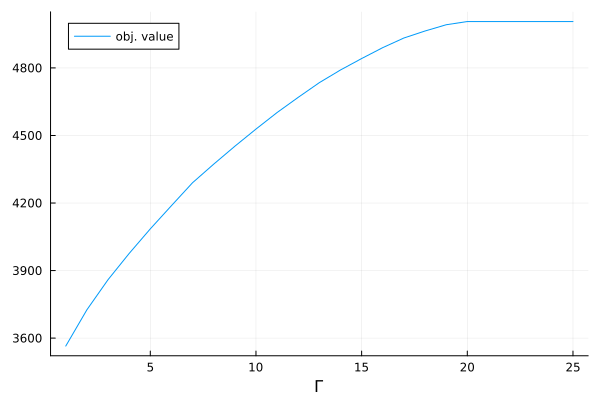

In [17]:
UB_k = []
for i in 1:25
    ⋅, ⋅, UB = ccg_decomposition(instance, max_iter = 5, Γ = i,)
    push!(UB_k, UB)
end

plot(UB_k, 
    label = "obj. value",
    xlabel = "Γ")